# Notebook de Aplicação do Modelo

#### Criação de um objeto spark

In [1]:
#import findspark
#findspark.init()
#findspark.find()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import to_date
from pyspark.sql.functions import round
import pyspark.sql.functions as F
import seaborn as sns
from collections import Counter
from pyspark.sql.functions import collect_list, collect_set

# Importação das bibliotecas necessárias para modelos
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# build our SparkSession

spark = SparkSession\
        .builder\
        .appName("BigData")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()

In [2]:
spark

In [3]:
pwd

'/home/jovyan/code/Projeto/Notebooks'

In [4]:
#Ler o dataset a usar
! ls -la datasets/

ls: cannot access 'datasets/': No such file or directory


<br>

## Encontrar e Ler as Pipelines Guardadas do Notebook Anterior 

In [5]:
# Carregar a pipeline de transformação
transformation_path = "../Datasets/variables_transformation_pipeline"
transformation_pipeline = Pipeline.load(transformation_path)

# Carregar a pipeline de K-Means
kmeans_path = "../Datasets/kmeans_pipeline"
kmeans_pipeline = Pipeline.load(kmeans_path)

# Carregar a pipeline do modelo aplicado ao dataset de verão
hot_path = "../Datasets/hot_pipeline"
hot_pipeline = PipelineModel.load(hot_path)

# Carregar a pipeline do modelo aplicado ao dataset de inverno
cold_path = "../Datasets/cold_pipeline"
cold_pipeline = PipelineModel.load(cold_path)



<br>

## Descarregar dados de teste

In [6]:
# Carregar os dados de teste do dataset de verão
ficheiro_hot = "../Datasets/hot_df_parquet.parquet"
hot_test = spark.read.parquet(ficheiro_hot)

# Carregar seus dados de teste (substitua com seus próprios dados)
ficheiro_cold = "../Datasets/cold_df_parquet.parquet"
cold_test = spark.read.parquet(ficheiro_cold)

<br>

## Aplicar  a pipeline de transformação aos datasets de teste

In [7]:
#Ajustar a pipeline aos datasets
encoded_hot_df = transformation_pipeline.fit(hot_test)
encoded_cold_df = transformation_pipeline.fit(cold_test)

#Transformar os datasets
transformed_hot_df = encoded_hot_df.transform(hot_test)
transformed_cold_df = encoded_cold_df.transform(cold_test)

<br>

## Aplicar as pipelines dos modelos aos datasets

In [8]:
clusters_hot = hot_pipeline.transform(transformed_hot_df)
clusters_hot.show(3)

clusters_cold = cold_pipeline.transform(transformed_cold_df)
clusters_cold.show(3)

+------------+----------------------+---------------+--------------+--------------+--------------+--------------+---------+--------+--------------+----------------+--------------+----------------+--------------------+--------------------+----------+
|household_id|avg_energy_median_mean|avg_energy_mean|avg_energy_max|avg_energy_std|avg_energy_sum|avg_energy_min|   status|tax_type|status_indexed|tax_type_indexed|status_encoded|tax_type_encoded|   unscaled_features|     scaled_features|prediction|
+------------+----------------------+---------------+--------------+--------------+--------------+--------------+---------+--------+--------------+----------------+--------------+----------------+--------------------+--------------------+----------+
|   MAC002632|               0.04117|        0.07513|       0.46386|       0.08927|        3.5933|       0.00673|Adversity|     Std|           1.0|             0.0| (3,[1],[1.0])|   (1,[0],[1.0])|[0.04117,0.07513,...|[0.55850518289515...|         2|


##### Adicionar a informação sobre os acorns aos resultados obtidos

In [9]:
# Importar a base de dados com a informação sobre as households
df_households = spark.read.options(header='True', inferSchema='True').csv("../Datasets/informations_households.csv")

#Fazer join entre df_households e clusters_hot
complete_cluster_hot = clusters_hot.join(df_households, clusters_hot["household_id"] == df_households["LCLid"], "left")

#Selecionar apenas as colunas relevantes na tabela anteriormente criada
complete_cluster_hot = complete_cluster_hot.select(clusters_hot["household_id"], clusters_hot["avg_energy_median_mean"], 
                                                   clusters_hot["avg_energy_mean"], clusters_hot["avg_energy_max"],
                                                   clusters_hot["avg_energy_std"], clusters_hot["avg_energy_sum"], 
                                                   clusters_hot["avg_energy_min"], clusters_hot["status"], 
                                                   clusters_hot["tax_type"], clusters_hot["status_indexed"], 
                                                   clusters_hot["tax_type_indexed"], clusters_hot["prediction"],
                                                   df_households["Acorn"])
complete_cluster_hot.show(3)

#Fazer join entre df_households e clusters_cold
complete_cluster_cold = clusters_cold.join(df_households, clusters_cold["household_id"] == df_households["LCLid"], "left")

#Selecionar apenas as colunas relevantes na tabela anteriormente criada
complete_cluster_cold = complete_cluster_cold.select(clusters_cold["household_id"], clusters_cold["avg_energy_median_mean"], 
                                                   clusters_cold["avg_energy_mean"], clusters_cold["avg_energy_max"],
                                                   clusters_cold["avg_energy_std"], clusters_cold["avg_energy_sum"], 
                                                   clusters_cold["avg_energy_min"], clusters_cold["status"], 
                                                   clusters_cold["tax_type"], clusters_cold["status_indexed"], 
                                                   clusters_cold["tax_type_indexed"], clusters_cold["prediction"],
                                                   df_households["Acorn"])
complete_cluster_cold.show(3)

+------------+----------------------+---------------+--------------+--------------+--------------+--------------+---------+--------+--------------+----------------+----------+-------+
|household_id|avg_energy_median_mean|avg_energy_mean|avg_energy_max|avg_energy_std|avg_energy_sum|avg_energy_min|   status|tax_type|status_indexed|tax_type_indexed|prediction|  Acorn|
+------------+----------------------+---------------+--------------+--------------+--------------+--------------+---------+--------+--------------+----------------+----------+-------+
|   MAC002632|               0.04117|        0.07513|       0.46386|       0.08927|        3.5933|       0.00673|Adversity|     Std|           1.0|             0.0|         2|ACORN-Q|
|   MAC000441|               0.09344|        0.11544|       0.43362|       0.09498|       5.54115|       0.02111| Affluent|     Std|           0.0|             0.0|         4|ACORN-E|
|   MAC003619|               0.08025|        0.10175|       0.46422|       0.081

## Análise dos Resultados

### Base de dados que contém apenas os meses quentes

In [10]:
#Número de observações por Cluster
complete_cluster_hot.select("prediction").groupBy("prediction").count().orderBy("prediction", ascending=True).show(truncate=False)

+----------+-----+
|prediction|count|
+----------+-----+
|0         |81   |
|1         |32   |
|2         |191  |
|3         |64   |
|4         |134  |
|5         |41   |
|6         |143  |
|7         |82   |
|8         |115  |
|9         |119  |
|10        |118  |
+----------+-----+



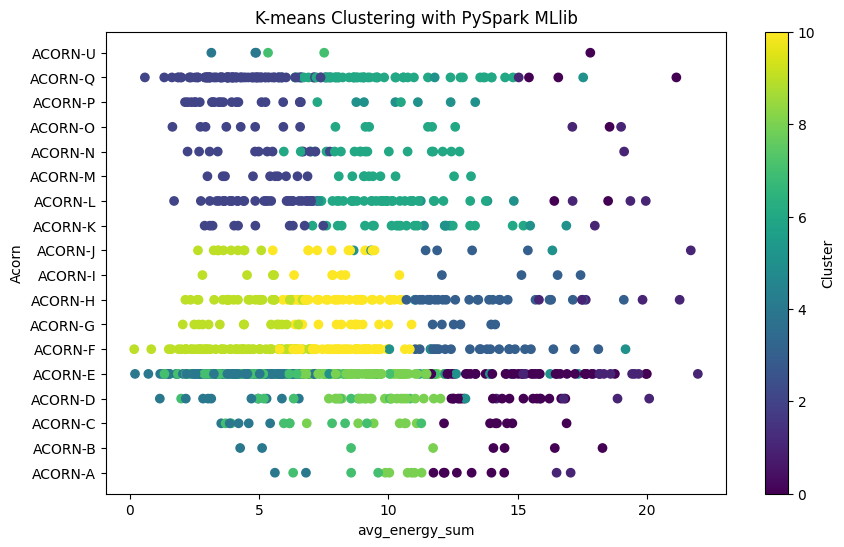

In [11]:
# Gráfico da Distribuição dos Clusters pelos tipos de Acorn 
# Preparação para a visualização dos dados
vis_df_hot = complete_cluster_hot.toPandas()

# Converter a coluna 'Acorn' para uma categoria ordenada
vis_df_hot['Acorn'] = pd.Categorical(vis_df_hot['Acorn'], categories=sorted(vis_df_hot['Acorn'].unique()), ordered=True)

# Ordenar o DataFrame pelo valor da coluna 'Acorn'
vis_df_hot = vis_df_hot.sort_values('Acorn')

# Criação do ScatterPlot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(vis_df_hot["avg_energy_sum"], vis_df_hot["Acorn"].cat.codes, c=vis_df_hot["prediction"], cmap='viridis')
plt.xlabel("avg_energy_sum")
plt.ylabel("Acorn")
plt.title("K-means Clustering with PySpark MLlib")
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster")
plt.yticks(range(len(vis_df_hot['Acorn'].cat.categories)), vis_df_hot['Acorn'].cat.categories)
plt.show()




In [12]:
# Acorns por cluster nos meses Quentes
cluster_per_acorn_hot = complete_cluster_hot.groupBy("prediction").agg(collect_set("Acorn").alias("Acorns")).orderBy("prediction").show(truncate = False)

+----------+------------------------------------------------------------------------------------------+
|prediction|Acorns                                                                                    |
+----------+------------------------------------------------------------------------------------------+
|0         |[ACORN-U, ACORN-L, ACORN-D, ACORN-E, ACORN-O, ACORN-A, ACORN-Q, ACORN-C, ACORN-B]         |
|1         |[ACORN-L, ACORN-H, ACORN-D, ACORN-E, ACORN-J, ACORN-O, ACORN-N, ACORN-K, ACORN-A, ACORN-Q]|
|2         |[ACORN-M, ACORN-P, ACORN-L, ACORN-O, ACORN-N, ACORN-K, ACORN-Q]                           |
|3         |[ACORN-I, ACORN-H, ACORN-J, ACORN-G, ACORN-F]                                             |
|4         |[ACORN-U, ACORN-D, ACORN-E, ACORN-A, ACORN-C, ACORN-B]                                    |
|5         |[ACORN-P, ACORN-L, ACORN-H, ACORN-D, ACORN-E, ACORN-J, ACORN-K, ACORN-Q, ACORN-F]         |
|6         |[ACORN-M, ACORN-P, ACORN-L, ACORN-O, ACORN-N, ACORN-

In [13]:
# Representação de cada Acorn nos clusters
# Agrupar e contar
count_df = complete_cluster_hot.groupBy('prediction', 'Acorn').count()

# Calcular o total de registros em cada cluster
total_count_per_cluster = count_df.groupBy('prediction').agg({'count': 'sum'}).withColumnRenamed('sum(count)', 'total_count')

# Juntar as duas tabelas para calcular a percentagem
percentage_df = count_df.join(total_count_per_cluster, 'prediction')
percentage_df = percentage_df.withColumn('percentage', col('count') / col('total_count') * 100)

# Selecionar e mostrar o resultado final
result_df = percentage_df.select('prediction', 'Acorn', 'count', 'total_count', 'percentage')
sorted_result_df = result_df.orderBy('prediction')

sorted_result_df.show(100)

+----------+-------+-----+-----------+------------------+
|prediction|  Acorn|count|total_count|        percentage|
+----------+-------+-----+-----------+------------------+
|         0|ACORN-E|   39|         81|48.148148148148145|
|         0|ACORN-A|    7|         81| 8.641975308641975|
|         0|ACORN-D|   17|         81| 20.98765432098765|
|         0|ACORN-L|    2|         81|2.4691358024691357|
|         0|ACORN-C|    7|         81| 8.641975308641975|
|         0|ACORN-B|    4|         81| 4.938271604938271|
|         0|ACORN-Q|    3|         81|3.7037037037037033|
|         0|ACORN-O|    1|         81|1.2345679012345678|
|         0|ACORN-U|    1|         81|1.2345679012345678|
|         1|ACORN-E|   11|         32|            34.375|
|         1|ACORN-D|    5|         32|            15.625|
|         1|ACORN-H|    5|         32|            15.625|
|         1|ACORN-O|    2|         32|              6.25|
|         1|ACORN-A|    2|         32|              6.25|
|         1|AC

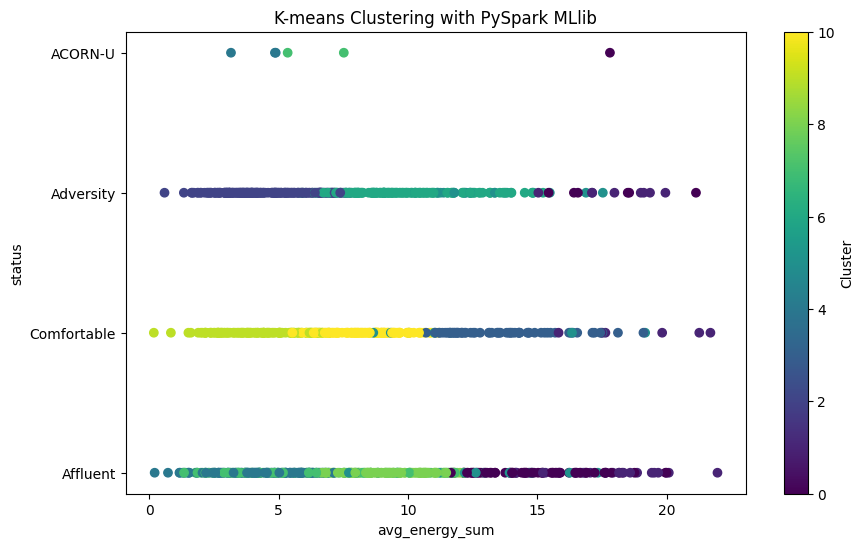

In [14]:
# Gráfico da Distribuição dos Clusters pelos tipos de Acorn 

plt.figure(figsize=(10, 6))
scatter = plt.scatter(vis_df_hot["avg_energy_sum"], vis_df_hot["status"], c=vis_df_hot["prediction"], cmap='viridis')
plt.xlabel("avg_energy_sum")
plt.ylabel("status")
plt.title("K-means Clustering with PySpark MLlib")
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster")
plt.show()


### Base de dados que contém apenas os meses frios

In [15]:
#Número de observações por Cluster
complete_cluster_cold.select("prediction").groupBy("prediction").count().orderBy("prediction", ascending=True).show(truncate=False)

+----------+-----+
|prediction|count|
+----------+-----+
|0         |72   |
|1         |104  |
|2         |198  |
|3         |122  |
|4         |66   |
|5         |137  |
|6         |136  |
|7         |80   |
|8         |49   |
|9         |110  |
|10        |46   |
+----------+-----+



<br>

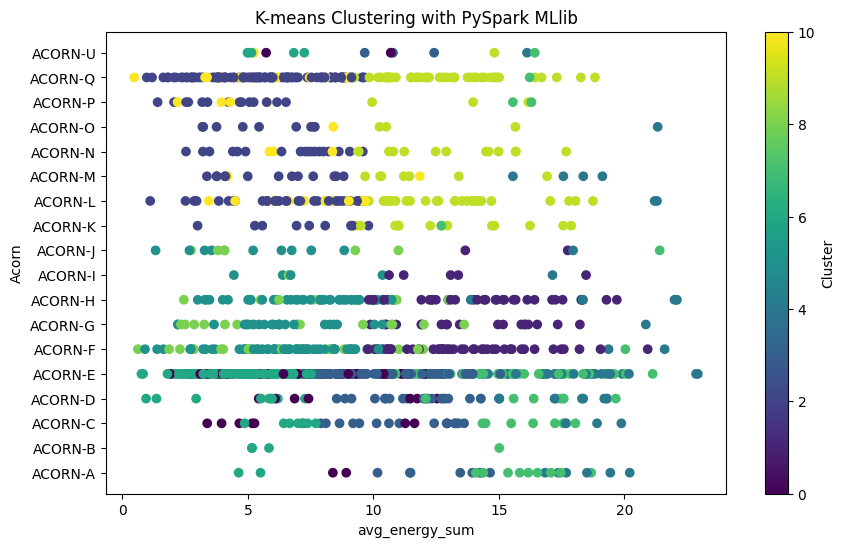

In [16]:
# Gráfico da Distribuição dos Clusters pelos tipos de Acorn 
# Preparação para a visualização dos dados
vis_df_cold = complete_cluster_cold.toPandas()

# Converter a coluna 'Acorn' para uma categoria ordenada
vis_df_cold['Acorn'] = pd.Categorical(vis_df_cold['Acorn'], categories=sorted(vis_df_cold['Acorn'].unique()), ordered=True)

# Ordenar o DataFrame pelo valor da coluna 'Acorn'
vis_df_cold = vis_df_cold.sort_values('Acorn')

# Criação do ScatterPlot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(vis_df_cold["avg_energy_sum"], vis_df_cold["Acorn"].cat.codes, c=vis_df_cold["prediction"], cmap='viridis')
plt.xlabel("avg_energy_sum")
plt.ylabel("Acorn")
plt.title("K-means Clustering with PySpark MLlib")
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster")
plt.yticks(range(len(vis_df_cold['Acorn'].cat.categories)), vis_df_cold['Acorn'].cat.categories)
plt.show()


In [17]:
# Acorns por cluster nos meses Frios
cluster_per_acorn_cold = complete_cluster_cold.groupBy("prediction").agg(collect_set("Acorn").alias("Acorns")).orderBy("prediction").show(truncate = False)

+----------+---------------------------------------------------------------------------------------------------------------------+
|prediction|Acorns                                                                                                               |
+----------+---------------------------------------------------------------------------------------------------------------------+
|0         |[ACORN-U, ACORN-D, ACORN-E, ACORN-A, ACORN-C]                                                                        |
|1         |[ACORN-I, ACORN-H, ACORN-J, ACORN-G, ACORN-F]                                                                        |
|2         |[ACORN-M, ACORN-P, ACORN-L, ACORN-O, ACORN-N, ACORN-K, ACORN-Q]                                                      |
|3         |[ACORN-U, ACORN-D, ACORN-E, ACORN-A, ACORN-C]                                                                        |
|4         |[ACORN-M, ACORN-U, ACORN-L, ACORN-H, ACORN-F, ACORN-D, ACORN-E, ACORN-J

In [18]:
# Representação de cada Acorn nos clusters
count_df = complete_cluster_cold.groupBy('prediction', 'Acorn').count()

# Calcular o total de registros em cada cluster
total_count_per_cluster = count_df.groupBy('prediction').agg({'count': 'sum'}).withColumnRenamed('sum(count)', 'total_count')

# Juntar as duas tabelas para calcular a percentagem
percentage_df = count_df.join(total_count_per_cluster, 'prediction')
percentage_df = percentage_df.withColumn('percentage', col('count') / col('total_count') * 100)

# Selecionar e mostrar o resultado final
result_df = percentage_df.select('prediction', 'Acorn', 'count', 'total_count', 'percentage')
sorted_result_df = result_df.orderBy('prediction')

sorted_result_df.show(100)

+----------+-------+-----+-----------+------------------+
|prediction|  Acorn|count|total_count|        percentage|
+----------+-------+-----+-----------+------------------+
|         0|ACORN-E|   53|         72| 73.61111111111111|
|         0|ACORN-A|    2|         72|2.7777777777777777|
|         0|ACORN-D|    7|         72| 9.722222222222223|
|         0|ACORN-C|    8|         72| 11.11111111111111|
|         0|ACORN-U|    2|         72|2.7777777777777777|
|         1|ACORN-H|   34|        104| 32.69230769230769|
|         1|ACORN-F|   44|        104| 42.30769230769231|
|         1|ACORN-I|    5|        104| 4.807692307692308|
|         1|ACORN-G|   19|        104|18.269230769230766|
|         1|ACORN-J|    2|        104|1.9230769230769231|
|         2|ACORN-Q|  104|        198| 52.52525252525253|
|         2|ACORN-M|   13|        198| 6.565656565656567|
|         2|ACORN-L|   31|        198|15.656565656565657|
|         2|ACORN-K|    9|        198| 4.545454545454546|
|         2|AC

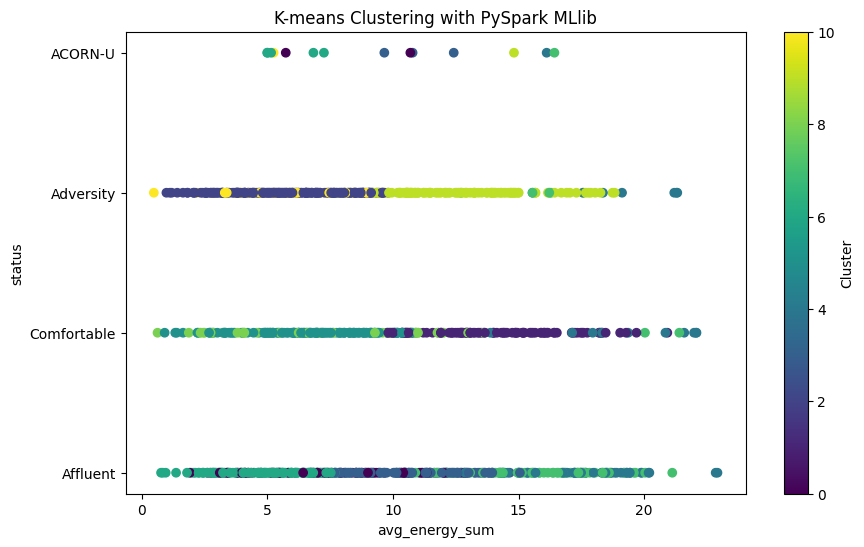

In [19]:
# Gráfico da Distribuição dos Clusters pelos tipos de Acorn 

# ScatterPlot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(vis_df_cold["avg_energy_sum"], vis_df_cold["status"], c=vis_df_cold["prediction"], cmap='viridis')
plt.xlabel("avg_energy_sum")
plt.ylabel("status")
plt.title("K-means Clustering with PySpark MLlib")
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster")
plt.show()

## Guardar os clusters formados em CSV

In [27]:
# Guardar os resultados do clustering aplicado nas bases de dados de teste
complete_cluster_hot.write.mode("overwrite").csv("../Datasets/hot_clusters.csv", header=True)
complete_cluster_cold.write.mode("overwrite").csv("../Datasets/cold_clusters.csv", header=True)